# 0. Imports

In [1]:
# Basic imports
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

# Functional imports
import json
import pyarrow
from pickle import dump

# Model imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest

# 1. Data Collection

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df_2018 = pd.read_parquet("/workspace/final_project/data/raw/Combined_Flights_2018.parquet", engine="pyarrow")
df_2019 = pd.read_parquet("/workspace/final_project/data/raw/Combined_Flights_2019.parquet", engine="pyarrow")
df_2020 = pd.read_parquet("/workspace/final_project/data/raw/Combined_Flights_2020.parquet", engine="pyarrow")
df_2021 = pd.read_parquet("/workspace/final_project/data/raw/Combined_Flights_2021.parquet", engine="pyarrow")
df_2022 = pd.read_parquet("/workspace/final_project/data/raw/Combined_Flights_2022.parquet", engine="pyarrow")

In [4]:
data_frames = [df_2018, df_2019, df_2020, df_2021, df_2022]
df = pd.concat(data_frames, ignore_index=True)

In [5]:
df.head()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2018-01-23,Endeavor Air Inc.,ABY,ATL,False,False,1202,1157.0,0.0,-5.0,1256.0,0.0,38.0,62.0,59.0,145.0,2018,1,1,23,2,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8928A,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,14.0,1211.0,1249.0,7.0,1304,-8.0,0.0,-1.0,1300-1359,1,0.0
1,2018-01-24,Endeavor Air Inc.,ABY,ATL,False,False,1202,1157.0,0.0,-5.0,1258.0,0.0,36.0,62.0,61.0,145.0,2018,1,1,24,3,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N800AY,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,13.0,1210.0,1246.0,12.0,1304,-6.0,0.0,-1.0,1300-1359,1,0.0
2,2018-01-25,Endeavor Air Inc.,ABY,ATL,False,False,1202,1153.0,0.0,-9.0,1302.0,0.0,40.0,62.0,69.0,145.0,2018,1,1,25,4,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8836A,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,18.0,1211.0,1251.0,11.0,1304,-2.0,0.0,-1.0,1300-1359,1,0.0
3,2018-01-26,Endeavor Air Inc.,ABY,ATL,False,False,1202,1150.0,0.0,-12.0,1253.0,0.0,35.0,62.0,63.0,145.0,2018,1,1,26,5,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N800AY,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,17.0,1207.0,1242.0,11.0,1304,-11.0,0.0,-1.0,1300-1359,1,0.0
4,2018-01-27,Endeavor Air Inc.,ABY,ATL,False,False,1400,1355.0,0.0,-5.0,1459.0,0.0,36.0,60.0,64.0,145.0,2018,1,1,27,6,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8839E,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1400-1459,17.0,1412.0,1448.0,11.0,1500,-1.0,0.0,-1.0,1500-1559,1,0.0


# 2.2 Exploration and Data cleaning

# Explicación de las columnas de datos de vuelos

### Información del vuelo
- **FlightDate**: Fecha del vuelo (año, mes y día).
- **Airline**: Código de la aerolínea que opera el vuelo.
- **Origin**: Código del aeropuerto de origen (IATA).
- **Dest**: Código del aeropuerto de destino (IATA).

### Indicadores de interrupción
- **Cancelled**: Indica si el vuelo fue cancelado (1 = Sí, 0 = No).
- **Diverted**: Indica si el vuelo fue desviado a otro aeropuerto (1 = Sí, 0 = No).

### Horarios de salida
- **CRSDepTime**: Hora programada de salida (horario planificado).
- **DepTime**: Hora real de salida del vuelo.
- **DepDelayMinutes**: Minutos de retraso en la salida.
- **DepDelay**: Retraso en la salida (valores negativos indican salida anticipada).

### Horarios de llegada
- **ArrTime**: Hora real de llegada del vuelo.
- **ArrDelayMinutes**: Minutos de retraso en la llegada.
- **ArrDelay**: Retraso en la llegada (valores negativos indican llegada anticipada).

### Duración del vuelo
- **AirTime**: Tiempo efectivo en el aire, en minutos.
- **CRSElapsedTime**: Tiempo total estimado del vuelo (planificado).
- **ActualElapsedTime**: Tiempo total real del vuelo.

### Distancia y ubicación
- **Distance**: Distancia entre los aeropuertos de origen y destino, en millas.

### Fechas y tiempo
- **Year**: Año del vuelo.
- **Quarter**: Trimestre del año (1 a 4).
- **Month**: Mes del año (1 a 12).
- **DayofMonth**: Día del mes.
- **DayOfWeek**: Día de la semana (1 = Lunes, 7 = Domingo).

### Información de la aerolínea
- **Marketing_Airline_Network**: Aerolínea responsable de vender el vuelo.
- **Operated_or_Branded_Code_Share_Partners**: Aerolíneas asociadas que operan el vuelo.
- **DOT_ID_Marketing_Airline**: Identificación del Departamento de Transporte (DOT) de la aerolínea de marketing.
- **IATA_Code_Marketing_Airline**: Código IATA de la aerolínea de marketing.
- **Flight_Number_Marketing_Airline**: Número del vuelo asignado por la aerolínea de marketing.
- **Operating_Airline**: Aerolínea que opera físicamente el vuelo.
- **DOT_ID_Operating_Airline**: Identificación del DOT de la aerolínea operativa.
- **IATA_Code_Operating_Airline**: Código IATA de la aerolínea operativa.

### Información de la aeronave
- **Tail_Number**: Matrícula o identificador único de la aeronave.
- **Flight_Number_Operating_Airline**: Número del vuelo asignado por la aerolínea operativa.

### Información del aeropuerto de origen
- **OriginAirportID**: Identificador único del aeropuerto de origen.
- **OriginAirportSeqID**: Secuencia única del aeropuerto de origen.
- **OriginCityMarketID**: Identificador de mercado de la ciudad de origen.
- **OriginCityName**: Nombre de la ciudad del aeropuerto de origen.
- **OriginState**: Abreviación del estado del aeropuerto de origen.
- **OriginStateFips**: Código FIPS del estado del aeropuerto de origen.
- **OriginStateName**: Nombre completo del estado del aeropuerto de origen.
- **OriginWac**: Código WAC (World Area Code) del aeropuerto de origen.

### Información del aeropuerto de destino
- **DestAirportID**: Identificador único del aeropuerto de destino.
- **DestAirportSeqID**: Secuencia única del aeropuerto de destino.
- **DestCityMarketID**: Identificador de mercado de la ciudad de destino.
- **DestCityName**: Nombre de la ciudad del aeropuerto de destino.
- **DestState**: Abreviación del estado del aeropuerto de destino.
- **DestStateFips**: Código FIPS del estado del aeropuerto de destino.
- **DestStateName**: Nombre completo del estado del aeropuerto de destino.
- **DestWac**: Código WAC (World Area Code) del aeropuerto de destino.

### Indicadores de retraso en la salida
- **DepDel15**: Indica si el vuelo tuvo un retraso mayor a 15 minutos en la salida (1 = Sí, 0 = No).
- **DepartureDelayGroups**: Clasificación del retraso en la salida por grupos de tiempo.
- **DepTimeBlk**: Bloque horario de la salida (por ejemplo, "0700-0759").

### Información de movimientos de la aeronave
- **TaxiOut**: Tiempo en minutos que la aeronave estuvo en la pista antes de despegar.
- **WheelsOff**: Hora en que las ruedas dejaron la pista durante el despegue.
- **WheelsOn**: Hora en que las ruedas tocaron la pista durante el aterrizaje.
- **TaxiIn**: Tiempo en minutos que la aeronave estuvo en la pista después de aterrizar.

### Indicadores de retraso en la llegada
- **CRSArrTime**: Hora programada de llegada (horario planificado).
- **ArrDel15**: Indica si el vuelo tuvo un retraso mayor a 15 minutos en la llegada (1 = Sí, 0 = No).
- **ArrivalDelayGroups**: Clasificación del retraso en la llegada por grupos de tiempo.
- **ArrTimeBlk**: Bloque horario de la llegada (por ejemplo, "0700-0759").

### Otros indicadores
- **DistanceGroup**: Clasificación de la distancia del vuelo por grupos.
- **DivAirportLandings**: Número de aterrizajes no programados en aeropuertos de desvío.

In [6]:
print('Our dataframe contains {} rows and it has {} features.'.format(len(df), df.shape[1]))

Our dataframe contains 29193782 rows and it has 61 features.


---

## 2.2 Identifying Duplicated and Null Values

In [7]:
df.describe()

,FlightDate,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,DOT_ID_Marketing_Airline,Flight_Number_Marketing_Airline,DOT_ID_Operating_Airline,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginStateFips,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestStateFips,DestWac,DepDel15,DepartureDelayGroups,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,DistanceGroup,DivAirportLandings
count,29193782,2.919378e+07,2.843213e+07,2.843070e+07,2.843070e+07,2.840760e+07,2.834760e+07,2.834122e+07,2.919376e+07,2.834814e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.919378e+07,2.843070e+07,2.843070e+07,2.841322e+07,2.841323e+07,2.840065e+07,2.840064e+07,2.919378e+07,2.834760e+07,2.834760e+07,2.834760e+07,2.919378e+07,2.919369e+07
mean,2020-04-23 22:27:03.485606,1.326262e+03,1.329296e+03,1.278311e+01,9.306866e+00,1.468046e+03,1.280992e+01,1.090875e+02,1.387605e+02,1.332941e+02,7.797346e+02,2.019829e+03,2.448568e+00,6.327840e+00,1.575161e+01,3.974879e+00,1.982793e+04,2.691383e+03,2.000173e+04,2.691343e+03,1.267630e+04,1.267634e+06,3.176109e+04,2.729479e+01,5.478744e+01,1.267628e+04,1.267632e+06,3.176111e+04,2.729502e+01,5.478760e+01,1.727673e-01,-1.609496e-02,1.671094e+01,1.352845e+03,1.463262e+03,7.532169e+00,1.489004e+03,3.609370e+00,1.766207e-01,-2.887085e-01,3.593297e+00,3.505826e-03
min,2018-01-01 00:00:00,1.000000e+00,1.000000e+00,0.000000e+00,-1.280000e+03,1.000000e+00,0.000000e+00,-1.244000e+03,-2.920000e+02,-1.228000e+03,1.600000e+01,2.018000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.939300e+04,1.000000e+00,1.939300e+04,1.000000e+00,1.013500e+04,1.013505e+06,3.007000e+04,1.000000e+00,1.000000e+00,1.013500e+04,1.013505e+06,3.007000e+04,1.000000e+00,1.000000e+00,0.000000e+00,-2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,-1.290000e+03,0.000000e+00,-2.000000e+00,1.000000e+00,0.000000e+00
25%,2019-03-18 00:00:00,9.180000e+02,9.200000e+02,0.000000e+00,-6.000000e+00,1.055000e+03,0.000000e+00,5.900000e+01,8.800000e+01,8.200000e+01,3.540000e+02,2.019000e+03,1.000000e+00,3.000000e+00,8.000000e+00,2.000000e+00,1.979000e+04,1.100000e+03,1.979000e+04,1.100000e+03,1.129200e+04,1.129202e+06,3.069300e+04,1.200000e+01,3.400000e+01,1.129200e+04,1.129202e+06,3.069300e+04,1.200000e+01,3.400000e+01,0.000000e+00,-1.000000e+00,1.100000e+01,9.350000e+02,1.051000e+03,4.000000e+00,1.108000e+03,-1.600000e+01,0.000000e+00,-2.000000e+00,2.000000e+00,0.000000e+00
50%,2020-02-08 00:00:00,1.320000e+03,1.323000e+03,0.000000e+00,-3.000000e+00,1.505000e+03,0.000000e+00,9.100000e+01,1.210000e+02,1.160000e+02,6.260000e+02,2.020000e+03,2.000000e+00,6.000000e+00,1.600000e+01,4.000000e+00,1.980500e+04,2.294000e+03,1.997700e+04,2.294000e+03,1.288900e+04,1.288903e+06,3.145300e+04,2.600000e+01,4.500000e+01,1.288900e+04,1.288903e+06,3.145300e+04,2.600000e+01,4.500000e+01,0.000000e+00,-1.000000e+00,1.400000e+01,1.336000e+03,1.501000e+03,6.000000e+00,1.515000e+03,-7.000000e+00,0.000000e+00,-1.000000e+00,3.000000e+00,0.000000e+00
75%,2021-07-17 00:00:00,1.730000e+03,1.736000e+03,5.000000e+00,5.000000e+00,1.910000e+03,6.000000e+00,1.380000e+02,1.690000e+02,1.640000e+02,1.014000e+03,2.021000e+03,3.000000e+00,9.000000e+00,2.300000e+01,6.000000e+00,1.997700e+04,4.256000e+03,2.037800e+04,4.255000e+03,1.405700e+04,1.405702e+06,3.257500e+04,4.200000e+01,8.200000e+01,1.405700e+04,1.405702e+06,3.257500e+04,4.200000e+01,8.200000e+01,0.000000e+00,0.000000e+00,1.900000e+01,1.750000e+03,1.905000e+03,9.000000e+00,1.915000e+03,6.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00
max,2022-07-31 00:00:00,2.359000e+03,2.400000e+03,7.223000e+03,

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29193782 entries, 0 to 29193781
Data columns (total 61 columns):
 #   Column                                   Dtype         
---  ------                                   -----         
 0   FlightDate                               datetime64[us]
 1   Airline                                  object        
 2   Origin                                   object        
 3   Dest                                     object        
 4   Cancelled                                bool          
 5   Diverted                                 bool          
 6   CRSDepTime                               int64         
 7   DepTime                                  float64       
 8   DepDelayMinutes                          float64       
 9   DepDelay                                 float64       
 10  ArrTime                                  float64       
 11  ArrDelayMinutes                          float64       
 12  AirTime                   

***Coclusion:***

Nuestro data frame contiene los siguientes tipos de datos:

- ``Booleanos`` --> 2
- ``Date time`` --> 1
- ``Float``     --> 19
- ``Integer``   --> 22
- ``String``    --> 17



In [9]:
df.isna().sum()[df.isna().sum()>0]

DepTime                 761652
DepDelayMinutes         763084
DepDelay                763084
ArrTime                 786177
ArrDelayMinutes         846183
AirTime                 852561
CRSElapsedTime              22
ActualElapsedTime       845637
Tail_Number             267613
DepDel15                763084
DepartureDelayGroups    763084
TaxiOut                 780561
WheelsOff               780551
WheelsOn                793133
TaxiIn                  793143
ArrDelay                846183
ArrDel15                846183
ArrivalDelayGroups      846183
DivAirportLandings          90
dtype: int64

In [10]:
df_without_na = df.dropna()

In [11]:
df_without_na.head()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2018-01-23,Endeavor Air Inc.,ABY,ATL,False,False,1202,1157.0,0.0,-5.0,1256.0,0.0,38.0,62.0,59.0,145.0,2018,1,1,23,2,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8928A,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,14.0,1211.0,1249.0,7.0,1304,-8.0,0.0,-1.0,1300-1359,1,0.0
1,2018-01-24,Endeavor Air Inc.,ABY,ATL,False,False,1202,1157.0,0.0,-5.0,1258.0,0.0,36.0,62.0,61.0,145.0,2018,1,1,24,3,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N800AY,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,13.0,1210.0,1246.0,12.0,1304,-6.0,0.0,-1.0,1300-1359,1,0.0
2,2018-01-25,Endeavor Air Inc.,ABY,ATL,False,False,1202,1153.0,0.0,-9.0,1302.0,0.0,40.0,62.0,69.0,145.0,2018,1,1,25,4,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8836A,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,18.0,1211.0,1251.0,11.0,1304,-2.0,0.0,-1.0,1300-1359,1,0.0
3,2018-01-26,Endeavor Air Inc.,ABY,ATL,False,False,1202,1150.0,0.0,-12.0,1253.0,0.0,35.0,62.0,63.0,145.0,2018,1,1,26,5,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N800AY,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,17.0,1207.0,1242.0,11.0,1304,-11.0,0.0,-1.0,1300-1359,1,0.0
4,2018-01-27,Endeavor Air Inc.,ABY,ATL,False,False,1400,1355.0,0.0,-5.0,1459.0,0.0,36.0,60.0,64.0,145.0,2018,1,1,27,6,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8839E,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1400-1459,17.0,1412.0,1448.0,11.0,1500,-1.0,0.0,-1.0,1500-1559,1,0.0


## 2.3 Eliminating Irrelevant Features and dealing with null values

### Identificacion de columnas irrelevantes:
#### ID relacionado con aereopuertos y ciudades:
- OriginAirportID, OriginAirportSeqID, OriginCityMarketID.
- DestAirportID, DestAirportSeqID, DestCityMarketID.
Razón: Informacion ya contenida en Origin, Dest, OriginCityName, y DestCityName.
#### Identificadores de aeronaves
- Tail_Number.
Razón: La identificacion de cada aeronave no es relevante para predecir retrasos.
- **DOT_ID_Marketing_Airline**: Identificación del Departamento de Transporte (DOT) de la aerolínea de marketing.
- **IATA_Code_Marketing_Airline**: Código IATA de la aerolínea de marketing.
- **Flight_Number_Marketing_Airline**: Número del vuelo asignado por la aerolínea de marketing.
- **DOT_ID_Operating_Airline**: Identificación del DOT de la aerolínea operativa.
- **IATA_Code_Operating_Airline**: Código IATA de la aerolínea operativa.

#### Detalles especificos de aeronaves
- DOT_ID_Marketing_Airline, DOT_ID_Operating_Airline, Flight_Number_Operating_Airline(revisar si dejar esta).
Razón: Las variables categóricas como Airline e IATA_Code_Marketing_Airline ya representan esta información.
#### Variables conectadas con otras
DepDelayMinutes y DepDelay: Estas varibles representan algo similar pero en diferente formato. (hay que definir si dejar solo una)
CRSElapsedTime y ActualElapsedTime: Considerar si dejar solo Delay, ya que la diferencia entre estas dos columnas ya se captura probablemente ya se considera en la columna delay.

- **TaxiOut**: Tiempo en minutos que la aeronave estuvo en la pista antes de despegar.
- **WheelsOff**: Hora en que las ruedas dejaron la pista durante el despegue.
- **WheelsOn**: Hora en que las ruedas tocaron la pista durante el aterrizaje.
- **TaxiIn**: Tiempo en minutos que la aeronave estuvo en la pista después de aterrizar.

### Manejo de valores nulos
Variables categoricas: ej. Airline, Origin

Variables numéricas ej. DepDelay, ArrDelay

Variables booleanas ej. Cancelled, Diverted

Considerar eliminar todos los valores nulos, dado que los nulos representan un 2.9% del total, eliminar esas filas podria no afectar significativamente el analisis.

Si una columna tiene un porcentaje alto de valores nulos (ej. más del 40%), como Tail_Number o DivAirportLandings, es mejor eliminarla.

In [12]:
counts = df['DivAirportLandings'].value_counts()

print(f"Cantidad de 0: {counts.get(0, 0)}")
print(f"Cantidad de 1: {counts.get(1, 0)}")

Cantidad de 0: 29121618
Cantidad de 1: 67881


# 3. Analysis

## 3.1 Univariate Analysis

In [13]:
df_without_na.drop(columns=["OriginAirportID", "OriginAirportSeqID", "OriginCityMarketID", "DestAirportID", "DestAirportSeqID", "DestCityMarketID", "Tail_Number", "DOT_ID_Marketing_Airline", "DOT_ID_Operating_Airline", "DepDelay", "TaxiOut", "WheelsOff", "WheelsOn", "TaxiIn"], axis = 1, inplace= True)
df_without_na.head()

/tmp/ipykernel_1269/3416218174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_na.drop(columns=["OriginAirportID", "OriginAirportSeqID", "OriginCityMarketID", "DestAirportID", "DestAirportSeqID", "DestCityMarketID", "Tail_Number", "DOT_ID_Marketing_Airline", "DOT_ID_Operating_Airline", "DepDelay", "TaxiOut", "WheelsOff", "WheelsOn", "TaxiIn"], axis = 1, inplace= True)


,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,IATA_Code_Operating_Airline,Flight_Number_Operating_Airline,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepDel15,DepartureDelayGroups,DepTimeBlk,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2018-01-23,Endeavor Air Inc.,ABY,ATL,False,False,1202,1157.0,0.0,1256.0,0.0,38.0,62.0,59.0,145.0,2018,1,1,23,2,DL,DL_CODESHARE,DL,3298,9E,9E,3298,"Albany, GA",GA,13,Georgia,34,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,1304,-8.0,0.0,-1.0,1300-1359,1,0.0
1,2018-01-24,Endeavor Air Inc.,ABY,ATL,False,False,1202,1157.0,0.0,1258.0,0.0,36.0,62.0,61.0,145.0,2018,1,1,24,3,DL,DL_CODESHARE,DL,3298,9E,9E,3298,"Albany, GA",GA,13,Georgia,34,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,1304,-6.0,0.0,-1.0,1300-1359,1,0.0
2,2018-01-25,Endeavor Air Inc.,ABY,ATL,False,False,1202,1153.0,0.0,1302.0,0.0,40.0,62.0,69.0,145.0,2018,1,1,25,4,DL,DL_CODESHARE,DL,3298,9E,9E,3298,"Albany, GA",GA,13,Georgia,34,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,1304,-2.0,0.0,-1.0,1300-1359,1,0.0
3,2018-01-26,Endeavor Air Inc.,ABY,ATL,False,False,1202,1150.0,0.0,1253.0,0.0,35.0,62.0,63.0,145.0,2018,1,1,26,5,DL,DL_CODESHARE,DL,3298,9E,9E,3298,"Albany, GA",GA,13,Georgia,34,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,1304,-11.0,0.0,-1.0,1300-1359,1,0.0
4,2018-01-27,Endeavor Air Inc.,ABY,ATL,False,False,1400,1355.0,0.0,1459.0,0.0,36.0,60.0,64.0,145.0,2018,1,1,27,6,DL,DL_CODESHARE,DL,3298,9E,9E,3298,"Albany, GA",GA,13,Georgia,34,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1400-1459,1500,-1.0,0.0,-1.0,1500-1559,1,0.0


In [14]:
#Separate categorical and numerical columns
categorical_columns = df_without_na.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df_without_na.select_dtypes(include=['number']).columns.tolist()

print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

Categorical columns: ['Airline', 'Origin', 'Dest', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'IATA_Code_Marketing_Airline', 'Operating_Airline', 'IATA_Code_Operating_Airline', 'OriginCityName', 'OriginState', 'OriginStateName', 'DestCityName', 'DestState', 'DestStateName', 'DepTimeBlk', 'ArrTimeBlk']
Numerical columns: ['CRSDepTime', 'DepTime', 'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Flight_Number_Marketing_Airline', 'Flight_Number_Operating_Airline', 'OriginStateFips', 'OriginWac', 'DestStateFips', 'DestWac', 'DepDel15', 'DepartureDelayGroups', 'CRSArrTime', 'ArrDelay', 'ArrDel15', 'ArrivalDelayGroups', 'DistanceGroup', 'DivAirportLandings']


In [15]:
df_without_na[categorical_columns].describe()

,Airline,Origin,Dest,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,IATA_Code_Marketing_Airline,Operating_Airline,IATA_Code_Operating_Airline,OriginCityName,OriginState,OriginStateName,DestCityName,DestState,DestStateName,DepTimeBlk,ArrTimeBlk
count,28339510,28339510,28339510,28339510,28339510,28339510,28339510,28339510,28339510,28339510,28339510,28339510,28339510,28339510,28339510,28339510
unique,28,388,388,11,16,11,28,28,381,53,53,381,53,53,19,19
top,Southwest Airlines Co.,ATL,ATL,AA,WN,AA,WN,WN,"Chicago, IL",CA,California,"Chicago, IL",CA,California,0600-0659,1600-1659
freq,5292591,1347020,1347297,6753273,5292591,6753273,5292591,5292591,1648445,3009550,3009550,1646008,3011342,3011342,1963894,1857765


In [16]:
df_without_na[numerical_columns].describe()

,CRSDepTime,DepTime,DepDelayMinutes,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Flight_Number_Marketing_Airline,Flight_Number_Operating_Airline,OriginStateFips,OriginWac,DestStateFips,DestWac,DepDel15,DepartureDelayGroups,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,DistanceGroup,DivAirportLandings
count,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07,2.833951e+07
mean,1.325326e+03,1.329147e+03,1.271745e+01,1.467977e+03,1.280957e+01,1.090895e+02,1.389525e+02,1.333201e+02,7.816336e+02,2.019824e+03,2.462051e+00,6.369937e+00,1.573960e+01,3.974908e+00,2.687269e+03,2.687227e+03,2.727079e+01,5.486550e+01,2.726996e+01,5.486423e+01,1.722425e-01,-1.981223e-02,1.488250e+03,3.608186e+00,1.766174e-01,-2.887862e-01,3.600690e+00,9.527335e-07
std,4.821373e+02,4.950206e+02,4.599462e+01,5.253428e+02,4.580092e+01,6.906774e+01,7.093263e+01,7.077064e+01,5.827334e+02,1.345638e+00,1.122092e+00,3.455985e+00,8.764440e+00,2.002243e+00,1.838617e+03,1.838627e+03,1.666834e+01,2.642207e+01,1.666967e+01,2.642456e+01,3.775911e-01,2.157985e+00,5.069481e+02,4.928063e+01,3.813446e-01,2.306326e+00,2.292695e+00,2.928242e-03
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-1.244000e+03,-2.920000e+02,-1.228000e+03,2.900000e+01,2.018000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-2.000000e+00,1.000000e+00,-1.290000e+03,0.000000e+00,-2.000000e+00,1.000000e+00,0.000000e+00
25%,9.160000e+02,9.190000e+02,0.000000e+00,1.055000e+03,0.000000e+00,5.900000e+01,8.800000e+01,8.200000e+01,3.560000e+02,2.019000e+03,1.000000e+00,3.000000e+00,8.000000e+00,2.000000e+00,1.097000e+03,1.097000e+03,1.200000e+01,3.400000e+01,1.200000e+01,3.400000e+01,0.000000e+00,-1.000000e+00,1.108000e+03,-1.600000e+01,0.000000e+00,-2.000000e+00,2.000000e+00,0.000000e+00
50%,1.318000e+03,1.323000e+03,0.000000e+00,1.505000e+03,0.000000e+00,9.100000e+01,1.210000e+02,1.160000e+02,6.280000e+02,2.020000e+03,2.000000e+00,6.000000e+00,1.600000e+01,4.000000e+00,2.288000e+03,2.288000e+03,2.600000e+01,4.500000e+01,2.600000e+01,4.500000e+01,0.000000e+00,-1.000000e+00,1.514000e+03,-7.000000e+00,0.000000e+00,-1.000000e+00,3.000000e+00,0.000000e+00
75%,1.730000e+03,1.736000e+03,5.000000e+00,1.910000e+03,6.000000e+00,1.380000e+02,1.690000e+02,1.640000e+02,1.017000e+03,2.021000e+03,3.000000e+00,9.000000e+00,2.300000e+01,6.000000e+00,4.249000e+03,4.248000e+03,4.200000e+01,8.200000e+01,4.200000e+01,8.200000e+01,0.000000e+00,0.000000e+00,1.914000e+03,6.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00
max,2.359000e+03,2.400000e+03,7.223000e+03,2.400000e+03,7.232000e+03,1.557000e+03,1.645000e+03,1.604000e+03,5.812000e+03,2.022000e+03,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,9.888000e+03,9.888000e+03,7.800000e+01,9.300000e+01,7.800000e+01,9.300000e+01,1.000000e+00,1.200000e+01,2.400000e+03,7.232000e+03,1.000000e+00,1.200000e+01,1.100000e+01,9.000000e+00


# 3.2 Categorical variables analysis

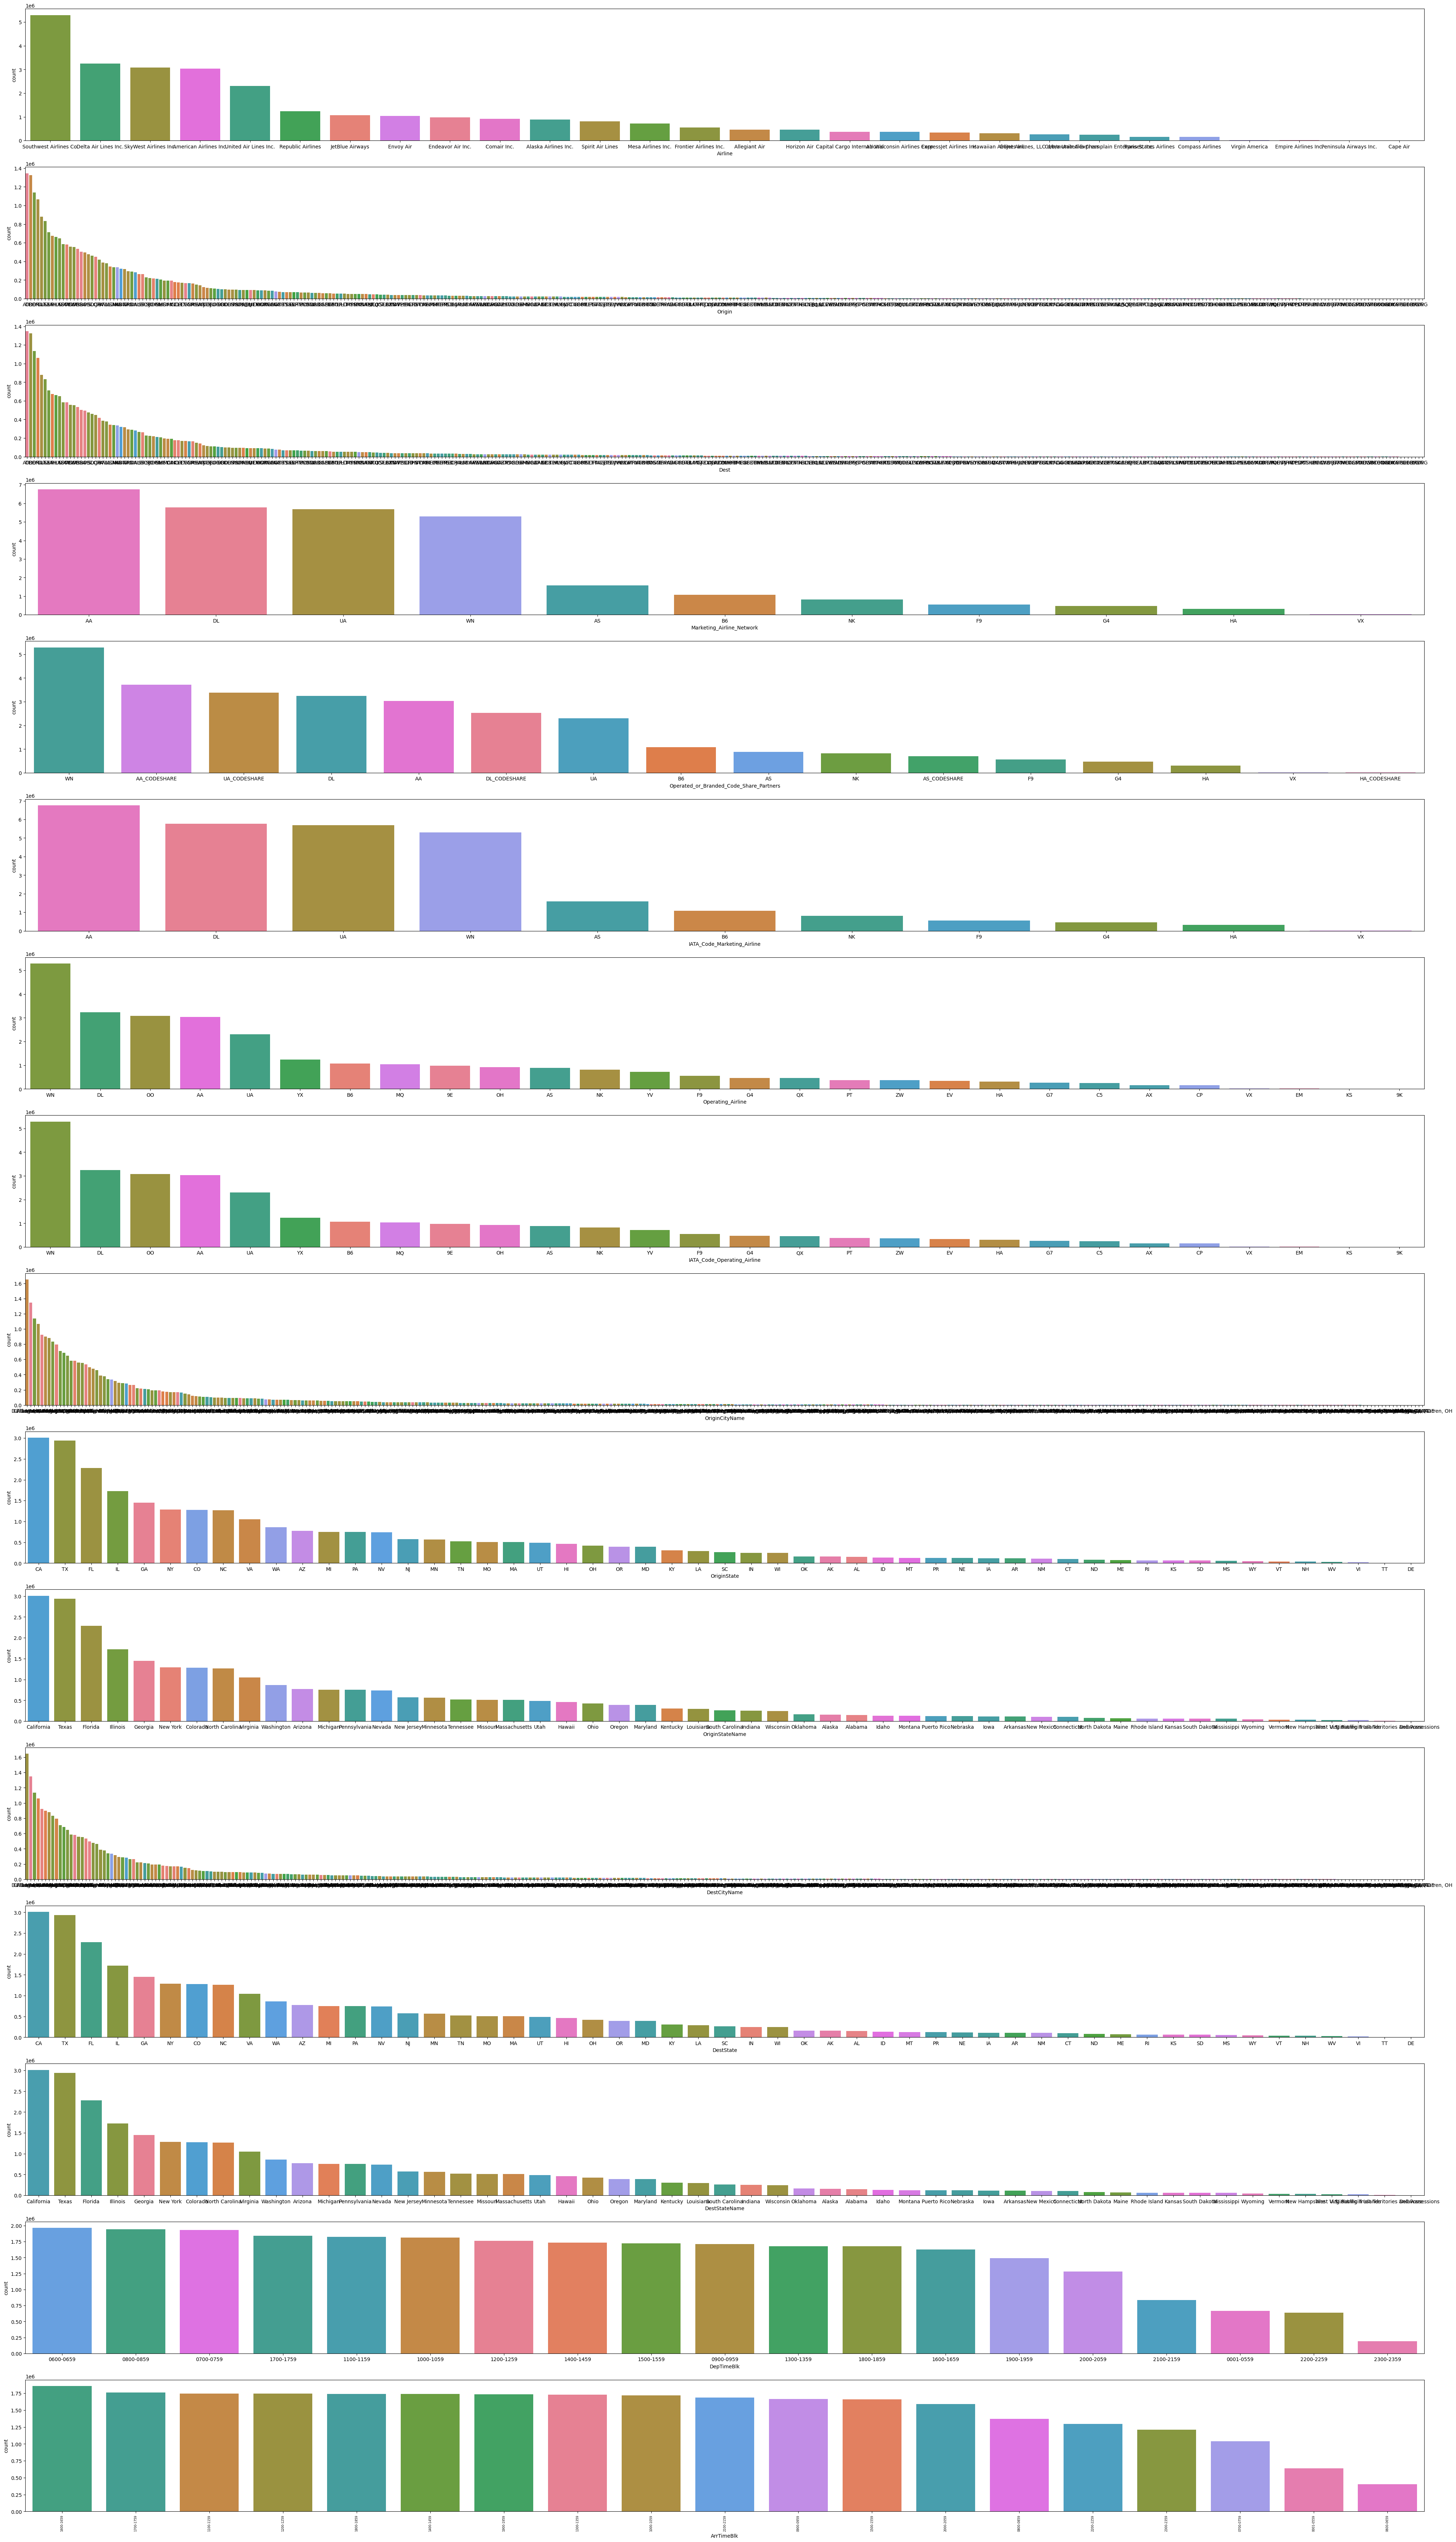

In [23]:
fig, ax = plt.subplots(16, 1, figsize = (50, 90))
sns.countplot(ax= ax[0], data = df_without_na, x = "Airline", order=df_without_na['Airline'].value_counts().index, hue='Airline')
sns.countplot(ax = ax[1], data = df_without_na, x = "Origin", order=df_without_na['Origin'].value_counts().index, hue='Origin')
sns.countplot(ax = ax[2], data = df_without_na, x = 'Dest', order=df_without_na['Dest'].value_counts().index, hue='Dest')
sns.countplot(ax = ax[3], data = df_without_na, x = 'Marketing_Airline_Network', order=df_without_na['Marketing_Airline_Network'].value_counts().index, hue='Marketing_Airline_Network')
sns.countplot(ax = ax[4], data = df_without_na, x = 'Operated_or_Branded_Code_Share_Partners', order=df_without_na['Operated_or_Branded_Code_Share_Partners'].value_counts().index, hue='Operated_or_Branded_Code_Share_Partners')
sns.countplot(ax = ax[5], data = df_without_na, x = 'IATA_Code_Marketing_Airline', order=df_without_na['IATA_Code_Marketing_Airline'].value_counts().index, hue='IATA_Code_Marketing_Airline')
sns.countplot(ax = ax[6], data = df_without_na, x = 'Operating_Airline', order=df_without_na['Operating_Airline'].value_counts().index, hue='Operating_Airline')
sns.countplot(ax = ax[7], data = df_without_na, x = 'IATA_Code_Operating_Airline', order=df_without_na['IATA_Code_Operating_Airline'].value_counts().index, hue='IATA_Code_Operating_Airline')
sns.countplot(ax = ax[8], data = df_without_na, x = 'OriginCityName', order=df_without_na['OriginCityName'].value_counts().index, hue='OriginCityName')
sns.countplot(ax = ax[9], data = df_without_na, x = 'OriginState', order=df_without_na['OriginState'].value_counts().index, hue='OriginState')
sns.countplot(ax = ax[10], data = df_without_na, x = 'OriginStateName', order=df_without_na['OriginStateName'].value_counts().index, hue='OriginStateName')
sns.countplot(ax = ax[11], data = df_without_na, x = 'DestCityName', order=df_without_na['DestCityName'].value_counts().index, hue='DestCityName')
sns.countplot(ax = ax[12], data = df_without_na, x = 'DestState', order=df_without_na['DestState'].value_counts().index, hue='DestState')
sns.countplot(ax = ax[13], data = df_without_na, x = 'DestStateName', order=df_without_na['DestStateName'].value_counts().index, hue='DestStateName')
sns.countplot(ax = ax[14], data = df_without_na, x = 'DepTimeBlk', order= df_without_na['DepTimeBlk'].value_counts().index, hue='DepTimeBlk')
sns.countplot(ax = ax[15], data = df_without_na, x = 'ArrTimeBlk', order=df_without_na['ArrTimeBlk'].value_counts().index, hue='ArrTimeBlk')

plt.xticks(rotation=90, fontsize=6)
plt.show()

# 3.3 Numerical variables analisys

In [25]:
fig, ax = plt.subplots(8, 2, figsize=(90, 90), gridspec_kw={'height_ratios': [6, 1, 6, 1, 6, 1, 6, 1]})

# Charts first row 
sns.histplot(ax = ax[0,0], data = df_without_na, x='DepDelayMinutes')
sns.boxplot(ax = ax[1,0], data = df_without_na, x='DepDelayMinutes')
sns.histplot(ax = ax[0,1], data = df_without_na, x='ArrDelayMinutes').set(ylabel = None)
sns.boxplot(ax = ax[1,1], data = df_without_na, x='ArrDelayMinutes')

# Charts second row 
sns.histplot(ax = ax[2,0], data = df_without_na, x='ArrivalDelayGroups').set(ylabel = None)
sns.boxplot(ax = ax[3,0], data = df_without_na, x='ArrivalDelayGroups')
sns.histplot(ax = ax[2,1], data = df_without_na, x='DayOfWeek')
sns.boxplot(ax = ax[3,1], data = df_without_na, x='DayOfWeek')

# Charts third row 
sns.histplot(ax = ax[4,0], data = df_without_na, x='DepDel15').set(ylabel = None)
sns.boxplot(ax = ax[5,0], data = df_without_na, x='DepDel15')
sns.histplot(ax = ax[4,1], data = df_without_na, x='ArrDel15').set(ylabel = None)
sns.boxplot(ax = ax[5,1], data = df_without_na, x='ArrDel15')

# Charts last row 
sns.histplot(ax = ax[6,0], data = df_without_na, x='OriginWac')
sns.boxplot(ax = ax[7,0], data = df_without_na, x='OriginWac')
sns.histplot(ax = ax[6,1], data = df_without_na, x='DestWac').set(ylabel = None)
sns.boxplot(ax = ax[7,1], data = df_without_na, x='DestWac')

plt.tight_layout()
plt.show()


# Explicación de las columnas de datos de vuelos

### Información del vuelo
- **FlightDate**: Fecha del vuelo (año, mes y día).
- **Airline**: Código de la aerolínea que opera el vuelo.
- **Origin**: Código del aeropuerto de origen (IATA).
- **Dest**: Código del aeropuerto de destino (IATA).

### Indicadores de interrupción
- **Cancelled**: Indica si el vuelo fue cancelado (1 = Sí, 0 = No).
- **Diverted**: Indica si el vuelo fue desviado a otro aeropuerto (1 = Sí, 0 = No).

### Horarios de salida
- **CRSDepTime**: Hora programada de salida (horario planificado).
- **DepTime**: Hora real de salida del vuelo.
- **DepDelayMinutes**: Minutos de retraso en la salida.
- **DepDelay**: Retraso en la salida (valores negativos indican salida anticipada).

### Horarios de llegada
- **ArrTime**: Hora real de llegada del vuelo.
- **ArrDelayMinutes**: Minutos de retraso en la llegada.
- **ArrDelay**: Retraso en la llegada (valores negativos indican llegada anticipada).

### Duración del vuelo
- **AirTime**: Tiempo efectivo en el aire, en minutos.
- **CRSElapsedTime**: Tiempo total estimado del vuelo (planificado).
- **ActualElapsedTime**: Tiempo total real del vuelo.

### Distancia y ubicación
- **Distance**: Distancia entre los aeropuertos de origen y destino, en millas.

### Fechas y tiempo
- **Year**: Año del vuelo.
- **Quarter**: Trimestre del año (1 a 4).
- **Month**: Mes del año (1 a 12).
- **DayofMonth**: Día del mes.
- **DayOfWeek**: Día de la semana (1 = Lunes, 7 = Domingo).

### Información de la aerolínea
- **Marketing_Airline_Network**: Aerolínea responsable de vender el vuelo.
- **Operated_or_Branded_Code_Share_Partners**: Aerolíneas asociadas que operan el vuelo.
- **DOT_ID_Marketing_Airline**: Identificación del Departamento de Transporte (DOT) de la aerolínea de marketing.
- **IATA_Code_Marketing_Airline**: Código IATA de la aerolínea de marketing.
- **Flight_Number_Marketing_Airline**: Número del vuelo asignado por la aerolínea de marketing.
- **Operating_Airline**: Aerolínea que opera físicamente el vuelo.
- **DOT_ID_Operating_Airline**: Identificación del DOT de la aerolínea operativa.
- **IATA_Code_Operating_Airline**: Código IATA de la aerolínea operativa.

### Información de la aeronave
- **Tail_Number**: Matrícula o identificador único de la aeronave.
- **Flight_Number_Operating_Airline**: Número del vuelo asignado por la aerolínea operativa.

### Información del aeropuerto de origen
- **OriginAirportID**: Identificador único del aeropuerto de origen.
- **OriginAirportSeqID**: Secuencia única del aeropuerto de origen.
- **OriginCityMarketID**: Identificador de mercado de la ciudad de origen.
- **OriginCityName**: Nombre de la ciudad del aeropuerto de origen.
- **OriginState**: Abreviación del estado del aeropuerto de origen.
- **OriginStateFips**: Código FIPS del estado del aeropuerto de origen.
- **OriginStateName**: Nombre completo del estado del aeropuerto de origen.
- **OriginWac**: Código WAC (World Area Code) del aeropuerto de origen.

### Información del aeropuerto de destino
- **DestAirportID**: Identificador único del aeropuerto de destino.
- **DestAirportSeqID**: Secuencia única del aeropuerto de destino.
- **DestCityMarketID**: Identificador de mercado de la ciudad de destino.
- **DestCityName**: Nombre de la ciudad del aeropuerto de destino.
- **DestState**: Abreviación del estado del aeropuerto de destino.
- **DestStateFips**: Código FIPS del estado del aeropuerto de destino.
- **DestStateName**: Nombre completo del estado del aeropuerto de destino.
- **DestWac**: Código WAC (World Area Code) del aeropuerto de destino.

### Indicadores de retraso en la salida
- **DepDel15**: Indica si el vuelo tuvo un retraso mayor a 15 minutos en la salida (1 = Sí, 0 = No).
- **DepartureDelayGroups**: Clasificación del retraso en la salida por grupos de tiempo.
- **DepTimeBlk**: Bloque horario de la salida (por ejemplo, "0700-0759").

### Información de movimientos de la aeronave
- **TaxiOut**: Tiempo en minutos que la aeronave estuvo en la pista antes de despegar.
- **WheelsOff**: Hora en que las ruedas dejaron la pista durante el despegue.
- **WheelsOn**: Hora en que las ruedas tocaron la pista durante el aterrizaje.
- **TaxiIn**: Tiempo en minutos que la aeronave estuvo en la pista después de aterrizar.

### Indicadores de retraso en la llegada
- **CRSArrTime**: Hora programada de llegada (horario planificado).
- **ArrDel15**: Indica si el vuelo tuvo un retraso mayor a 15 minutos en la llegada (1 = Sí, 0 = No).
- **ArrivalDelayGroups**: Clasificación del retraso en la llegada por grupos de tiempo.
- **ArrTimeBlk**: Bloque horario de la llegada (por ejemplo, "0700-0759").

### Otros indicadores
- **DistanceGroup**: Clasificación de la distancia del vuelo por grupos.
- **DivAirportLandings**: Número de aterrizajes no programados en aeropuertos de desvío.